In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
import csv


In [20]:
# Activating google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **I. Data Preprocessing: missing value**

<BarContainer object of 85 artists>

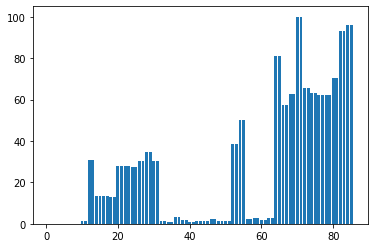

In [ ]:
df = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/pd_res.csv")
percent = (df.isnull().sum()/df.shape[0] * 100.00).to_list()
plt.bar(list(range(1, len(percent) + 1)), percent)

In [ ]:
# Try drop columns where the missingness is greater than 50
idices = np.where(np.array(percent)>50)[0]
df.drop(df.columns[idices], axis=1, inplace=True)
df.drop(columns=["RecordID_last","RecordID_mean"], inplace=True)

In [ ]:
# Try
# 1) replace the rest with mean
df1 = df.fillna(df.mean())
# 2) replace the rest with median
df2 = df.fillna(df.median())


In [ ]:
# 3) impute value with nearest neighbor
subset = df.dropna()
rest = [i for i in range(len(df)) if i not in subset.index]

filled = []
for idx in rest:
  array = df.iloc[idx].to_numpy()
  indices = []
  for i in range(len(array)):
    if i != 0 and (not np.isnan(array[i])):
      indices.append(i)
  to_compare = subset.iloc[:, indices].to_numpy()
  temp = np.take(array, indices)
  min_dist = np.inf
  min_idx = None
  for j in range(len(to_compare)):
    candidate = to_compare[j, :]
    dist = sum((temp-candidate)**2)
    if dist < min_dist:
      min_dist = dist
      min_idx = j
  nearest = subset.iloc[min_idx]
  #fill the array
  for k in range(len(array)):
    if np.isnan(array[k]):
      array[k] = nearest[k]
  filled.append(array)
  

In [ ]:
subset = subset.to_numpy()
filled = np.array(filled)
all = np.vstack([subset, filled])
df3 = pd.DataFrame(all, index=all[:, 0])
df3.to_csv("./drive/MyDrive/503_Data_Challenge_individual/imputation.csv")

NameError: ignored

In [ ]:
# Test each dataset with RF, check the cross validation value

y = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/train_outcome.csv")
Xy1 = pd.merge(df1, y,left_index=True, right_index=True)
X1 = Xy1[df1.columns].to_numpy()[:, 1:]
Xy2 = pd.merge(df2, y,left_index=True, right_index=True)
X2 = Xy2[df2.columns].to_numpy()[:, 1:]
Xy3 = pd.merge(df3, y,left_index=True, right_index=True)
X3 = Xy3[df3.columns].to_numpy()[:, 1:]
y = y.outcome.to_numpy()

In [ ]:
clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(clf, X1, y, cv=5)
np.mean(scores)

0.7281733095904755

In [ ]:
scores2 = cross_val_score(clf, X2, y, cv=5)
np.mean(scores2)

0.7240813494808656

In [ ]:
clf = RandomForestClassifier(n_estimators=100)
scores3 = cross_val_score(clf, X3, y, cv=5)
np.mean(scores3)

0.6569320949621411

# **I. Data Preprocessing: correlation and boxplot**

In [ ]:
df1.drop(columns=["Age_mean", "Gender_mean", "AdmissionType_mean"], inplace=True)

In [ ]:
corr = df1.iloc[:, 1:].corr()
plt = corr.style.background_gradient(cmap='coolwarm')
plt

In [ ]:
c = corr.abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
result = pd.DataFrame(so)
result = result[(abs(result[0]) > 0.5) & (result[0] != 1.0)]
result.to_csv("./drive/MyDrive/503_Data_Challenge_individual/high-correlation.csv")

[None, None, None, None, None, None]

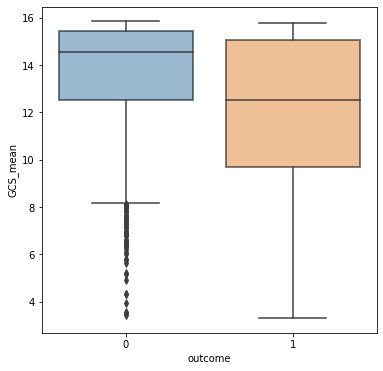

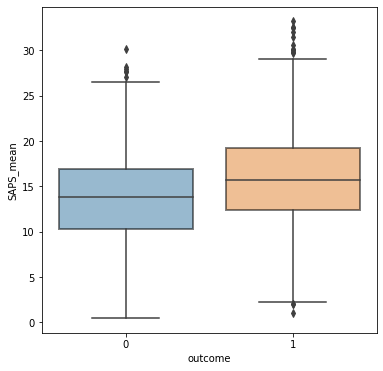

In [ ]:
y = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/train_outcome.csv")

# GCS boxplot
plt.figure(figsize = (6,6))
bp = sns.boxplot(x=y['outcome'], y='GCS_mean', data=df1)
plt.setp(bp.artists, alpha=.5, linewidth=2, edgecolor="k")

# SAPS boxplot
plt.figure(figsize = (6,6))
bp = sns.boxplot(x=y['outcome'], y='SAPS_mean', data=df1)
plt.setp(bp.artists, alpha=.5, linewidth=2, edgecolor="k")

#  **II.Model Fitting**

In [ ]:
df6 = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/pd_res.csv")
percent = (df6.isnull().sum()/df6.shape[0] * 100.00).to_list()
idices = np.where(np.array(percent)>50)[0].tolist()
idices.remove(79) # respiration
df6.drop(df6.columns[idices], axis=1, inplace=True)
df6.drop(columns=["RecordID_last","RecordID_mean"], inplace=True)

In [ ]:
# Features are dropped by 1) correlation > 0.9, 2) duplicated info such as age mean and age last 3) low Feature imporatance of RF model
df6.drop(columns=["Age_mean", "Gender_mean", 'Gender_last', "AdmissionType_mean"], inplace=True)

In [ ]:
df6.drop(columns=["HCO3_mean","HCO3_mean","pH_mean","pH_mean","BUN_mean",
"BUN_mean","Platelets_mean","Platelets_mean","Creatinine_mean","Creatinine_mean",
"SAPS_mean",'FiO2_last'], inplace=True)

In [ ]:
df6 = df6.fillna(df6.mean())

## Random Forest

In [ ]:

y = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/train_outcome.csv")
Xy6 = pd.merge(df6, y, left_index=True, right_index=True)
y = y.outcome
X6 = Xy6.drop(columns=['outcome', 'Unnamed: 0','id']).to_numpy()

avg_auc = 0
avg_ber = 0
for i in range(10):
  X_train, X_val, y_train, y_val = train_test_split(X6, y,  test_size=0.3)
  clf1 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
  probs = clf1.predict_proba(X_val)[:,1]
  auc = roc_auc_score(y_val, probs)
  y_pred = clf1.predict(X_val)
  ber = 1 - balanced_accuracy_score(y_pred, y_val)
  avg_auc += auc
  avg_ber += ber

avg_auc /= 10
avg_ber /= 10
print('AUC: %.3f' % avg_auc)
print('BER: %.3f' % avg_ber)

AUC: 0.760
BER: 0.306


## Gradient Boost

In [ ]:
##  We iteratively select hyper-parameters by the two criteria. The tuned classifier is
GradientBoostingClassifier(n_estimators=80, min_samples_split=100,random_state=50)

## code
# scores = ['roc_auc', 'balanced_accuracy']
# for score in scores:
#   param_test2 = {'loss': ['deviance', 'exponential']}
#   gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=80, min_samples_split=100,random_state=50), 
#   param_grid = param_test2, scoring=score, n_jobs=4,cv=5)
#   gsearch2.fit(X9, y)
#   print(gsearch2.best_params_, gsearch2.best_score_)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=100,
                           min_weight_fraction_leaf=0.0, n_estimators=80,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
avg_auc = 0
avg_ber = 0
for i in range(10):
  X_train, X_val, y_train, y_val = train_test_split(X6, y,  test_size=0.3)
  clf2 = GradientBoostingClassifier(n_estimators=50, min_samples_split=100, random_state=50).fit(X_train, y_train)
  probs = clf2.predict_proba(X_val)[:,1]
  auc = roc_auc_score(y_val, probs)
  y_pred = clf2.predict(X_val)
  ber = 1 - balanced_accuracy_score(y_pred, y_val)
  avg_auc += auc
  avg_ber += ber

avg_auc /= 10
avg_ber /= 10
print('AUC: %.3f' % auc)
print('BER: %.3f' % ber)

AUC: 0.766
BER: 0.309


# Extreme Gradient Boost (XGboost)
* note that we have found the method works better than GB later, so we hold the selected variables (in the section III) and tune the model.
---



In [ ]:
max_min = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/max_min.csv")
y = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/train_outcome.csv")
changes = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/change_and_change_rate2.csv")
test_nolabel = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/test_nolabel.csv")

max_min = max_min.fillna(max_min.mean())
changes = changes.fillna(changes.mean())
added1 = max_min[['HR_max', 'SysABP_max']]
added2 = changes[['PaO2_change_rate']]
Xy9 = pd.merge(df6, added1, left_index=True, right_index=True)
Xy9 = pd.merge(Xy9, added2, left_index=True, right_index=True)

X9 = pd.merge(Xy9, y, left_index=True, right_index=True)
X9 = X9.drop(columns=['outcome','Unnamed: 0', 'id']).to_numpy()
y = y.outcome

In [ ]:
##  We iteratively select hyper-parameters by the two criteria. The tuned classifier is
XGBClassifier(learning_rate=0.01, n_estimators=1200, max_depth=9, min_child_weight=50, gamma=0.2,colsample_bytree=0.75,subsample=0.8,reg_alpha=0.1)

## code
# scores = ['roc_auc', 'balanced_accuracy']
# for score in scores:
#   param_test2 = {'learning_rate':[0.001,0.002,0.005,0.01]  }
#   gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.01, n_estimators=1200,min_child_weight=50, gamma=0.2, colsample_bytree=0.75,subsample=0.8,reg_alpha=0.1, ), 
#   param_grid = param_test2, scoring=score, n_jobs=4,cv=5)
#   gsearch2.fit(X9, y)
#   print(gsearch2.best_params_, gsearch2.best_score_)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0.2,
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=50, missing=None, n_estimators=1200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [ ]:
avg_auc = 0
avg_ber = 0
for i in range(10):
  X_train, X_val, y_train, y_val = train_test_split(X9, y,  test_size=0.3)
  clf2 =  XGBClassifier(learning_rate=0.01, n_estimators=1200, max_depth=9, min_child_weight=50, gamma=0.2,colsample_bytree=0.75,subsample=0.8,reg_alpha=0.1).fit(X_train, y_train)
  probs = clf2.predict_proba(X_val)[:,1]
  auc = roc_auc_score(y_val, probs)
  y_pred = clf2.predict(X_val)
  ber = 1 - balanced_accuracy_score(y_pred, y_val)
  avg_auc += auc
  avg_ber += ber
avg_auc /= 10
avg_ber /= 10
print('AUC: %.3f' % auc)
print('BER: %.3f' % ber)

AUC: 0.786
BER: 0.297


## Logistic Regression

In [ ]:
# Auto variable selection by LR_L1
def LR_L1_selection (X, y, num_feature):
  sel_ = SelectFromModel(LogisticRegression(C=1, solver='saga', penalty='l1'), max_features=num_feature)
  sel_.fit(X, y)
  arr = sel_.get_support()
  length = num_feature
  num_xtrain = len(X)
  new_xtrain = np.zeros((num_xtrain,length))
  j = 0
  for i,v in enumerate(arr) :
      if v==True:
          new_xtrain[:, j] = X[:, i]
          j+=1
  return new_xtrain

In [ ]:
X7 = LR_L1_selection(X6, y, 40)
avg_auc = 0
avg_ber = 0
for _ in range(10):
  X_train7, X_val7, y_train7, y_val7 = train_test_split(X7, y, test_size=0.30)
  clf3 = LogisticRegression().fit(X_train7, y_train7)
  probs = clf3.predict_proba(X_val7)[:,1]
  auc = roc_auc_score(y_val7, probs)
  y_pred = clf3.predict(X_val7)
  ber = 1 - balanced_accuracy_score(y_pred, y_val7)
  avg_auc += auc
  avg_ber += ber
avg_auc /= 10
avg_ber /= 10
print('AUC: %.3f' % auc)
print('BER: %.3f' % ber)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    htt

AUC: 0.748
BER: 0.334


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# **III. Feature Selection from the additional dataset**

 Adding max,min and change,change_rate \
 \
 feature selection strategy:

 > Step 1:
 use a merged dataframe with added data,
 fit a GB and run 10 times
 each time record the top features containing max/min or change/change_rate.
 Then select candidate variable manually from the top features.


 > Step2:
 add features one by one, each time select a feature that increases performance

In [ ]:
y = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/train_outcome.csv")
max_min = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/max_min.csv")
max_min = max_min.fillna(max_min.mean())
Xy7 = pd.merge(max_min, y, left_index=True, right_index=True)
Xy7 = pd.merge(Xy7, df6, left_index=True, right_index=True)
y = y.outcome
X7 = Xy7.drop(columns=['outcome','Unnamed: 0', 'id']).to_numpy()

top_ten = dict()

for i in range(10):
  X_train, X_val, y_train, y_val = train_test_split(X7, y,  test_size=0.3)
  clf2 = GradientBoostingClassifier(n_estimators=50, min_samples_split=100, random_state=50).fit(X_train, y_train)
  probs = clf2.predict_proba(X_val)[:,1]
  auc = roc_auc_score(y_val, probs)
  res = Xy7.drop(columns=['outcome','Unnamed: 0', 'id']).columns
  importances = clf2.feature_importances_
  indices = np.argsort(importances)[::-1]
  lines = []
  for f in range(X7.shape[1]):
    if 'min' in res[indices[f]] or 'max' in res[indices[f]]:
      lines.append(res[indices[f]])
  for line in lines[:10]:
    if line in top_ten:
      top_ten[line] += 1
    else:
      top_ten[line] = 1
print(sorted(top_ten.items(), key=lambda x:-x[1]))


[('HR_max', 10), ('SysABP_max', 10), ('pH_max', 9), ('HR_min', 9), ('RespRate_max', 9), ('PaO2_min', 7), ('Albumin_min', 7), ('Urine_max', 5), ('pH_min', 5), ('Platelets_min', 5), ('BUN_min', 4), ('Na_min', 3), ('HCT_min', 2), ('DiasABP_min', 2), ('HCO3_min', 2), ('Glucose_max', 2), ('BUN_max', 2), ('MechVent_max', 2), ('Bilirubin_max', 1), ('DiasABP_max', 1), ('Creatinine_max', 1), ('Platelets_max', 1), ('NISysABP_min', 1)]


In [ ]:
candidates = ['SysABP_max', 'HR_max', 'RespRate_max','pH_max','Albumin_min','PaO2_min','HR_min','Urine_max','pH_min','Platelets_min']
best = 0.766 ## base score from the last dataframe
best_ber = 0.309 ## base score from the last dataframe
new_in = []
count = 0 ## if run the loop more than 5 times, manually break due to the memory usage


while len(new_in) < 3 and count < 5:
  best_feature = ""
  for feature in candidates:
    temp = [feature] + new_in
    added = max_min[temp]
    Xy8 = pd.merge(added, df6, left_index=True, right_index=True)
    y = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/train_outcome.csv")
    Xy8 = pd.merge(Xy8, y, left_index=True, right_index=True)
    X8 = Xy8.drop(columns=['outcome','Unnamed: 0','id']).to_numpy()
    y = y.outcome.to_numpy()

    sum_auc = 0
    sum_ber = 0
    for i in range(10):
      X_train, X_val, y_train, y_val = train_test_split(X8, y,  test_size=0.3)
      clf = GradientBoostingClassifier(n_estimators=50, min_samples_split=100, random_state=50).fit(X_train, y_train)
      probs = clf.predict_proba(X_val)[:,1]
      sum_auc += roc_auc_score(y_val, probs)
      y_pred = clf.predict(X_val)
      sum_ber += (1 - balanced_accuracy_score(y_pred, y_val))
    auc = sum_auc/10
    ber = sum_ber/10

    if auc > best and ber < best_ber:
      best = auc
      best_ber = ber
      best_feature = feature
      print("==========>")
      print(feature)
      print('Averaged AUC: %.5f' % (auc))
      print('Averaged BER: %.5f' % (ber))
  if best_feature != "":
    print("~~~ Best ~~~~~~>")
    print(best_feature)
    candidates.remove(best_feature)
    new_in.append(best_feature)
  count += 1
  print(count)

==========>
HR_max
Averaged AUC: 0.76713
Averaged BER: 0.30759
~~~ Best ~~~~~~>
HR_max
1
2
==========>
SysABP_max
Averaged AUC: 0.77278
Averaged BER: 0.30648
~~~ Best ~~~~~~>
SysABP_max
3
4
5


In [ ]:
## add change and change rate
y = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/train_outcome.csv")
changes = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/change_and_change_rate2.csv")
changes = changes.fillna(changes.mean())
Xy7 = pd.merge(changes, y, left_index=True, right_index=True)
Xy7 = pd.merge(Xy7, df6, left_index=True, right_index=True)
y = y.outcome
X7 = Xy7.drop(columns=['outcome','Unnamed: 0','id']).to_numpy()

top_ten = dict()

for i in range(10):
  X_train, X_val, y_train, y_val = train_test_split(X7, y,  test_size=0.3)
  clf2 = GradientBoostingClassifier(n_estimators=50, min_samples_split=100, random_state=50).fit(X_train, y_train)
  probs = clf2.predict_proba(X_val)[:,1]
  auc = roc_auc_score(y_val, probs)
  res = Xy7.drop(columns=['outcome','Unnamed: 0', 'id']).columns
  importances = clf2.feature_importances_
  indices = np.argsort(importances)[::-1]
  lines = []
  for f in range(X7.shape[1]):
    if 'change' in res[indices[f]] or 'change_rate' in res[indices[f]]:
      lines.append(res[indices[f]]) 
  for line in lines[:10]:
    if line in top_ten:
      top_ten[line] += 1
    else:
      top_ten[line] = 1
print(sorted(top_ten.items(), key=lambda x:-x[1]))


[('RespRate_change', 10), ('PaO2_change', 10), ('WBC_change', 10), ('PaO2_change_rate', 9), ('GCS_change', 9), ('FiO2_change_rate', 8), ('DiasABP_change_rate', 6), ('BUN_change', 6), ('PaCO2_change', 5), ('Glucose_change', 4), ('NIMAP_change', 4), ('RespRate_change_rate', 3), ('SysABP_change', 2), ('MechVent_change_rate', 2), ('DiasABP_change', 2), ('ALP_change', 1), ('Urine_change_rate', 1), ('TroponinT_change', 1), ('WBC_change_rate', 1), ('Glucose_change_rate', 1), ('AST_change', 1), ('PaCO2_change_rate', 1), ('NIMAP_change_rate', 1), ('Na_change', 1), ('Urine_change', 1)]


In [ ]:
candidates = ['RespRate_change','PaO2_change','WBC_change','PaO2_change_rate','GCS_change','FiO2_change_rate','DiasABP_change_rate', 'BUN_change','PaCO2_change']
best = 0.77278 ## base score from the last dataframe
best_ber = 0.30648 ## base score from the last dataframe
new_in = []
count = 0 ## if run the loop more than  5 times, manually break due to the memory usage

while len(new_in) < 3 and count < 5:
  best_feature = ""
  for feature in candidates:
    added0 = max_min[['HR_max', 'SysABP_max']]
    temp = [feature] + new_in
    added = changes[temp]
    Xy8 = pd.merge(df6, added0, left_index=True, right_index=True)
    Xy8 = pd.merge(Xy8, added, left_index=True, right_index=True)
    y = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/train_outcome.csv")
    Xy8 = pd.merge(Xy8, y, left_index=True, right_index=True)
    X8 = Xy8.drop(columns=['outcome','Unnamed: 0','id']).to_numpy()
    y = y.outcome.to_numpy()

    sum_auc = 0
    sum_ber = 0
    for i in range(10):
      X_train, X_val, y_train, y_val = train_test_split(X8, y,  test_size=0.3)
      clf = GradientBoostingClassifier(n_estimators=50, min_samples_split=100, random_state=50).fit(X_train, y_train)
      probs = clf.predict_proba(X_val)[:,1]
      sum_auc += roc_auc_score(y_val, probs)
      y_pred = clf.predict(X_val)
      sum_ber += (1 - balanced_accuracy_score(y_pred, y_val))
    auc = sum_auc/10
    ber = sum_ber/10

    if auc > best and ber < best_ber:
      best = auc
      best_ber = ber
      best_feature = feature
      print("==========>")
      print(feature)
      print('Averaged AUC: %.5f' % (auc))
      print('Averaged BER: %.5f' % (ber))
  if best_feature != "":
    print("~~~ Best ~~~~~~>")
    print(best_feature)
    candidates.remove(best_feature)
    new_in.append(best_feature)
  count += 1
  print(count)



1
2
==========>
PaO2_change_rate
Averaged AUC: 0.77390
Averaged BER: 0.30384
~~~ Best ~~~~~~>
PaO2_change_rate
3
4
5


# **IV. Prediction**
predict the test data

In [ ]:
max_min = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/max_min.csv")
y = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/train_outcome.csv")
changes = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/change_and_change_rate2.csv")
test_nolabel = pd.read_csv("./drive/MyDrive/503_Data_Challenge_individual/test_nolabel.csv")

max_min = max_min.fillna(max_min.mean())
changes = changes.fillna(changes.mean())
added1 = max_min[['HR_max', 'SysABP_max']]
added2 = changes[['PaO2_change_rate']]
Xy9 = pd.merge(df6, added1, left_index=True, right_index=True)
Xy9 = pd.merge(Xy9, added2, left_index=True, right_index=True)

train_X = pd.merge(Xy9, y, left_index=True, right_index=True)
train_X = train_X.drop(columns=['outcome','Unnamed: 0', 'id']).to_numpy()
train_y = y.outcome

idx = test_nolabel.id.to_list()
idx = [i-1 for i in idx]
test_X = (Xy9.iloc[idx,:]).drop(columns=['Unnamed: 0']).to_numpy()

In [ ]:
clf = XGBClassifier(learning_rate=0.01, n_estimators=1200, max_depth=9, min_child_weight=50, gamma=0.2,colsample_bytree=0.75,subsample=0.8,reg_alpha=0.1).fit(train_X, train_y)
pred = clf.predict(test_X)
probs = clf.predict_proba(test_X)[:,1]

In [ ]:
lines = [['id', 'outcome', 'score']]
count = 0
for i in idx:
  j = i + 1
  lines.append([j, pred[count], probs[count]])
  count += 1

In [ ]:
output_path = "./drive/MyDrive/503_Data_Challenge_individual/test2.csv"
with open(output_path, "w") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(lines)